In [1]:
!pip uninstall -y torch torchtext

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121


In [3]:
!pip install torch==2.0.1 torchtext==0.15.2

In [4]:
import torch
import torchtext
print("PyTorch Version:", torch.__version__)
print("TorchText Version:", torchtext.__version__)

PyTorch Version: 2.0.1+cu117
TorchText Version: 0.15.2+cpu


#import libraries

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import collections
import matplotlib.pyplot as plt
import pandas as pd

# Set seed for reproducibility
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from torchtext.data.utils import get_tokenizer
import pandas as pd
import numpy as np
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split


#Load the data

In [6]:
train_data = pd.read_csv('/content/train.csv')  # Main dataset
test_data = pd.read_csv('/content/test.csv')      # To be used for final evaluation

print("Train data sample:")
print(train_data.head())
print("test data sample:")
print(test_data.head())

Train data sample:
      text_id                                           sentence  gold_label
0  r1-0051002             Cheers,\n\nDennis Nguyen\n416-879-6431           0
1  r1-0020356               May have to wait longer on holidays.          -1
2  r1-0058348    I drove to vegas may 6th,  to get my hair done.           0
3  r1-0080006  In addition, I eat out often at various restau...           1
4  r1-0000827                  Perhaps she was doing us a favor?           0
test data sample:
      text_id                                           sentence
0  r1-0086521  A helpful valet at the Bellagio said it was a ...
1  r1-0044715  People often ask "what happened to the human c...
2  r1-0060690  He explained there would be a diagnostic fee o...
3  r1-0016852    I had initially purchased a massage on Groupon.
4  r2-0006040  Primarily do high-end cars as they get referra...


In [7]:
# Check for missing values in train and test data
print("The missing values in train data are as follows :")
print(train_data.isnull().sum())

print("\n The Missing values in test data are as follows:")
print(test_data.isnull().sum())



The missing values in train data are as follows :
text_id       0
sentence      0
gold_label    0
dtype: int64

 The Missing values in test data are as follows:
text_id     0
sentence    0
dtype: int64


In [8]:
print("Columns in train data:", train_data.columns)

Columns in train data: Index(['text_id', 'sentence', 'gold_label'], dtype='object')


In [9]:
# Basic text cleaning
import re

def clean_text(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

train_data['cleaned_sentence'] = train_data['sentence'].apply(clean_text)


In [10]:
# Printing some cleaned data to check
print("\nCleaned Train Data Sample:")
print(train_data[['sentence', 'cleaned_sentence']].head())



Cleaned Train Data Sample:
                                            sentence  \
0             Cheers,\n\nDennis Nguyen\n416-879-6431   
1               May have to wait longer on holidays.   
2    I drove to vegas may 6th,  to get my hair done.   
3  In addition, I eat out often at various restau...   
4                  Perhaps she was doing us a favor?   

                                    cleaned_sentence  
0                    cheers dennis nguyen 4168796431  
1                may have to wait longer on holidays  
2       i drove to vegas may 6th to get my hair done  
3  in addition i eat out often at various restaur...  
4                   perhaps she was doing us a favor  


In [11]:
print("Columns in train data:", train_data.columns)

Columns in train data: Index(['text_id', 'sentence', 'gold_label', 'cleaned_sentence'], dtype='object')


#mapping the labels to 0,1,2

In [12]:
from sklearn.model_selection import train_test_split

# Replace 'sentence' content with 'cleaned_sentence'
train_data['sentence'] = train_data['cleaned_sentence']

# Drop the original 'cleaned_sentence' column
train_data = train_data.drop(columns=['cleaned_sentence'])


In [13]:
print("Columns in train data:", train_data.columns)

Columns in train data: Index(['text_id', 'sentence', 'gold_label'], dtype='object')


In [14]:

train_data['gold_label'] = train_data['gold_label'].map({-1: 0, 0: 1, 1: 2})


In [15]:
# Spliting the the training data into 85% train and 15% , 90% 10%, 80/20 validation
train_split, valid_split = train_test_split(train_data, test_size=0.20, random_state=seed)

print(f"Training set size: {len(train_split)}")
print(f"Validation set size: {len(valid_split)}")

Training set size: 73782
Validation set size: 18446


I am using basic_english tried spacy but more or less this works better

In [16]:
tokenizer = get_tokenizer("basic_english")

def tokenize_example(row, max_length=256):
    tokens = tokenizer(row["sentence"])[:max_length]
    return {"tokens": tokens, "length": len(tokens)}

In [17]:
train_split["tokenized"] = train_split.apply(tokenize_example, axis=1)
valid_split["tokenized"] = valid_split.apply(tokenize_example, axis=1)

#print
print("Tokenized training data sample:")
print(train_split["tokenized"].head())


Tokenized training data sample:
66609    {'tokens': ['wow', 'that', 'sounds', 'like', '...
9234     {'tokens': ['really', 'deserves', 'negative', ...
84490    {'tokens': ['was', 'told', 'i', 'would', 'get'...
9610     {'tokens': ['aftercare', 'most', 'times', 'whe...
87631    {'tokens': ['line', 'does', 'go', 'by', 'quick...
Name: tokenized, dtype: object


In [18]:
# Yield tokens from the tokenized column in train_split
def yield_tokens(data):
    for item in data["tokenized"]:
        yield item["tokens"]



# using torchtext build_vocab _from_iterator

In [19]:
min_freq = 5
vocab = build_vocab_from_iterator(yield_tokens(train_split), min_freq=min_freq, specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])  # Set default index to <unk>

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 8113


In [20]:
# Function to convert tokens to numerical indices
def numericalize_example(row, vocab):
    ids = vocab.lookup_indices(row["tokenized"]["tokens"])
    return {"ids": ids, "length": row["tokenized"]["length"], "label": row["gold_label"]}

In [22]:
train_split["numericalized"] = train_split.apply(lambda x: numericalize_example(x, vocab), axis=1)
valid_split["numericalized"] = valid_split.apply(lambda x: numericalize_example(x, vocab), axis=1)

# Eror - converted to list
train_data_numericalized = train_split["numericalized"].to_list()
valid_data_numericalized = valid_split["numericalized"].to_list()

# Verify
print(f"Numericalized training data size: {len(train_data_numericalized)}")
print(f"Numericalized validation data size: {len(valid_data_numericalized)}")


Numericalized training data size: 73782
Numericalized validation data size: 18446


In [23]:
print("Columns in train_split:", train_split.columns)


Columns in train_split: Index(['text_id', 'sentence', 'gold_label', 'tokenized', 'numericalized'], dtype='object')


In [24]:
print(train_split["tokenized"].head())


66609    {'tokens': ['wow', 'that', 'sounds', 'like', '...
9234     {'tokens': ['really', 'deserves', 'negative', ...
84490    {'tokens': ['was', 'told', 'i', 'would', 'get'...
9610     {'tokens': ['aftercare', 'most', 'times', 'whe...
87631    {'tokens': ['line', 'does', 'go', 'by', 'quick...
Name: tokenized, dtype: object


In [25]:
def numericalize_example(row, vocab):
    ids = vocab.lookup_indices(row["tokenized"]["tokens"])  # Access 'tokens' within the 'tokenized' dict
    return {"ids": ids, "length": row["tokenized"]["length"], "label": row["gold_label"]}


Now using the numericaliztion to train and valid ddataset

In [26]:
# train dataset
train_split["numericalized"] = train_split.apply(
    lambda x: numericalize_example(x, vocab), axis=1
)

# valod dataset
valid_split["numericalized"] = valid_split.apply(
    lambda x: numericalize_example(x, vocab), axis=1
)

# Verify it
print("Numericalized train_split sample:")
print(train_split["numericalized"].head())


Numericalized train_split sample:
66609    {'ids': [979, 15, 1146, 39, 482, 5, 50, 36, 0,...
9234     {'ids': [91, 1865, 783, 178, 549], 'length': 5...
84490    {'ids': [7, 136, 3, 49, 37, 5, 219, 129, 101, ...
9610     {'ids': [0, 196, 156, 45, 20, 383, 2, 976, 73,...
87631    {'ids': [273, 423, 55, 69, 502, 32, 30, 35, 39...
Name: numericalized, dtype: object


In [27]:
print(train_split.iloc[0])  # Ensure all keys ('tokenized', 'gold_label') are present


text_id                                                 r2-0016087
sentence              wow that sounds like such a good time uh huh
gold_label                                                       2
tokenized        {'tokens': ['wow', 'that', 'sounds', 'like', '...
numericalized    {'ids': [979, 15, 1146, 39, 482, 5, 50, 36, 0,...
Name: 66609, dtype: object


In [28]:
print("Test dataset1 sample:")
print(test_data.head())

Test dataset1 sample:
      text_id                                           sentence
0  r1-0086521  A helpful valet at the Bellagio said it was a ...
1  r1-0044715  People often ask "what happened to the human c...
2  r1-0060690  He explained there would be a diagnostic fee o...
3  r1-0016852    I had initially purchased a massage on Groupon.
4  r2-0006040  Primarily do high-end cars as they get referra...


In [29]:
# Verify by checking the first entry
print(train_split.iloc[0])



text_id                                                 r2-0016087
sentence              wow that sounds like such a good time uh huh
gold_label                                                       2
tokenized        {'tokens': ['wow', 'that', 'sounds', 'like', '...
numericalized    {'ids': [979, 15, 1146, 39, 482, 5, 50, 36, 0,...
Name: 66609, dtype: object


#custome collate function

In [30]:
from torch.utils.data import DataLoader

def get_collate_fn(pad_index):
    def collate_fn(batch):
        # ids, length, and label
        batch_ids = [torch.tensor(row["numericalized"]["ids"]) for row in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = torch.tensor([row["numericalized"]["length"] for row in batch])
        batch_label = torch.tensor([row["numericalized"]["label"] for row in batch])

        return {
            "ids": batch_ids,
            "length": batch_length,
            "label": batch_label
        }
    return collate_fn



In [31]:
from torch.utils.data import DataLoader

def get_data_loader(data, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    return DataLoader(data.to_dict(orient="records"), batch_size=batch_size, collate_fn=collate_fn, shuffle=shuffle)


In [32]:
print(train_split.columns)


Index(['text_id', 'sentence', 'gold_label', 'tokenized', 'numericalized'], dtype='object')


In [33]:
print(train_split["numericalized"].head())


66609    {'ids': [979, 15, 1146, 39, 482, 5, 50, 36, 0,...
9234     {'ids': [91, 1865, 783, 178, 549], 'length': 5...
84490    {'ids': [7, 136, 3, 49, 37, 5, 219, 129, 101, ...
9610     {'ids': [0, 196, 156, 45, 20, 383, 2, 976, 73,...
87631    {'ids': [273, 423, 55, 69, 502, 32, 30, 35, 39...
Name: numericalized, dtype: object


In [34]:
batch_size = 64 # experimented with 64, 128, 256
pad_index = vocab["<pad>"]

train_data_loader = get_data_loader(train_split, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_split, batch_size, pad_index)

# Test a batch
print("First batch from train_data_loader:")
for batch in train_data_loader:
    print(batch)
    break  # Only check the first batch


First batch from train_data_loader:
{'ids': tensor([[  10,  503,   29,  ...,    1,    1,    1],
        [   0,  188,   15,  ...,    1,    1,    1],
        [   3,  149,    1,  ...,    1,    1,    1],
        ...,
        [  19,  106, 1744,  ...,    1,    1,    1],
        [  13, 1145, 1610,  ...,    1,    1,    1],
        [3853,    2,  273,  ...,    1,    1,    1]]), 'length': tensor([12,  3,  2, 11, 11,  9,  4,  5, 27, 27, 15, 19, 15, 17, 17, 12, 25, 10,
         2,  3, 14, 14, 12, 25, 26, 23, 20,  5,  6,  7, 24,  8, 17,  8, 18,  9,
         9,  8, 27,  7, 27, 14,  9, 19, 13,  4,  3,  3, 10,  5, 39, 26,  3, 14,
        14, 16,  2, 24, 13, 11,  8,  6,  9,  7]), 'label': tensor([0, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2,
        0, 2, 1, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1, 2, 2, 2, 0,
        1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1])}


1. Input
2. embedding
3. LSTM
4. GRU
5. attention
6. Transformer
7. combined output
8  BN
9. FC
10 prediction

In [35]:
# Layer 1
class TokenEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx, dropout_p):
        super(TokenEmbedding, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
        self.dropout_layer = nn.Dropout(dropout_p)

    def forward(self, input_tokens):
        embeddings = self.embedding_layer(input_tokens)
        return self.dropout_layer(embeddings)

    def load_pretrained_weights(self, pretrained_weights):
        self.embedding_layer.weight.data.copy_(pretrained_weights)

In [36]:
# RNN Layer
class RecurrentLayer(nn.Module):
    def __init__(self, rnn_type, input_dim, hidden_dim, num_layers, bidirectional, dropout_p):
        super(RecurrentLayer, self).__init__()
        if rnn_type == "lstm":
            self.rnn = nn.LSTM(
                input_size=input_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                dropout=dropout_p if num_layers > 1 else 0,
                batch_first=True,
            )
        elif rnn_type == "gru":
            self.rnn = nn.GRU(
                input_size=input_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                dropout=dropout_p if num_layers > 1 else 0,
                batch_first=True,
            )
        else:
            raise ValueError("Unsupported RNN type. Use 'lstm' or 'gru'.")

    def forward(self, packed_input):
        packed_output, hidden_state = self.rnn(packed_input)
        unpacked_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        return unpacked_output, hidden_state


In [37]:
# Attention Mechanism
class AttentionModule(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        self.attention_score_layer = nn.Linear(feature_dim, 1)

    def forward(self, rnn_outputs):
        attention_weights = torch.softmax(self.attention_score_layer(rnn_outputs), dim=1)
        context_vector = torch.sum(rnn_outputs * attention_weights, dim=1)
        return context_vector


In [38]:
# Transformer Encoder Layer
class TransformerLayer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, dropout_p):
        super(TransformerLayer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=num_heads, dropout=dropout_p
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, embeddings):
        encoder_output = self.encoder(embeddings.transpose(0, 1))
        return encoder_output.transpose(0, 1)


In [40]:
#Combined - EnsembleModel
class SentimentAnalysisEnsemble(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        num_rnn_layers,
        bidirectional,
        dropout_p,
        padding_idx,
        num_heads,
        num_transformer_layers,
    ):
        super(SentimentAnalysisEnsemble, self).__init__()
        # Modules
        self.embedding_layer = TokenEmbedding(vocab_size, embedding_dim, padding_idx, dropout_p)
        self.lstm_layer = RecurrentLayer("lstm", embedding_dim, hidden_dim, num_rnn_layers, bidirectional, dropout_p)
        self.gru_layer = RecurrentLayer("gru", embedding_dim, hidden_dim, num_rnn_layers, bidirectional, dropout_p)
        self.lstm_attention = AttentionModule(hidden_dim * 2 if bidirectional else hidden_dim)
        self.gru_attention = AttentionModule(hidden_dim * 2 if bidirectional else hidden_dim)
        self.transformer_layer = TransformerLayer(embedding_dim, num_heads, num_transformer_layers, dropout_p)
        self.classifier = nn.Linear(
            hidden_dim * 2 * (2 if bidirectional else 1) + embedding_dim, output_dim
        )
        self.batch_norm = nn.BatchNorm1d(
            hidden_dim * 2 * (2 if bidirectional else 1) + embedding_dim
        )
        self.regularizer_dropout = nn.Dropout(dropout_p)

    def forward(self, input_tokens, sequence_lengths):
        #embedding
        embeddings = self.embedding_layer(input_tokens)

        #inputs packed
        packed_embeddings = nn.utils.rnn.pack_padded_sequence(
            embeddings, sequence_lengths, batch_first=True, enforce_sorted=False
        )

        #lstm
        lstm_output, _ = self.lstm_layer(packed_embeddings)
        lstm_attention_output = self.lstm_attention(lstm_output)

        #gru
        gru_output, _ = self.gru_layer(packed_embeddings)
        gru_attention_output = self.gru_attention(gru_output)

        #transformer
        transformer_output = self.transformer_layer(embeddings)
        transformer_pooled = transformer_output.mean(dim=1)

        #combine-features
        combined_features = torch.cat([lstm_attention_output, gru_attention_output, transformer_pooled], dim=-1)
        normalized_features = self.batch_norm(combined_features)

        #final output
        final_prediction = self.classifier(normalized_features)
        return final_prediction

In [80]:
# Hyperparameter setting for different modules

num_embeddings = len(vocab)
embedding_dim = 300 # this will be 300 for golove 300
hidden_dim = 500  # 200 300 400 500
output_dim = train_data["gold_label"].nunique()  # Unique sentiment classes
num_layers = 3 # 2, 3, 4
bidirectional = True
dropout_p = 0.5  # 0.3, 0.5. 0.6
padding_idx = vocab["<pad>"]
num_heads = 5  # 2, 3, 5, 6, 10
num_transformer_layers = 6 # 2, 3, 4

model = SentimentAnalysisEnsemble(
    num_embeddings,
    embedding_dim,
    hidden_dim,
    output_dim,
    num_layers,
    bidirectional,
    dropout_p,
    padding_idx,
    num_heads,
    num_transformer_layers=num_transformer_layers,
)

#printing the model
print(model)


SentimentAnalysisEnsemble(
  (embedding_layer): TokenEmbedding(
    (embedding_layer): Embedding(8113, 300, padding_idx=1)
    (dropout_layer): Dropout(p=0.5, inplace=False)
  )
  (lstm_layer): RecurrentLayer(
    (rnn): LSTM(300, 500, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (gru_layer): RecurrentLayer(
    (rnn): GRU(300, 500, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (lstm_attention): AttentionModule(
    (attention_score_layer): Linear(in_features=1000, out_features=1, bias=True)
  )
  (gru_attention): AttentionModule(
    (attention_score_layer): Linear(in_features=1000, out_features=1, bias=True)
  )
  (transformer_layer): TransformerLayer(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
      )
      (linear1): Linear(in_features=300, out_features=2048, bias=True)
      (dropout): Dropout

In [81]:
#count the total params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 40,244,241 trainable parameters


In [82]:
# weight initalizer "He" bcoz of RelU else "Xavier"

import torch.nn as nn

def weight_initializer(layer):
    #checking layerwise
    if isinstance(layer, nn.Linear):
        # error - applicable only 2+ dimensions
        if layer.weight is not None and layer.weight.dim() > 1:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)
    elif isinstance(layer, (nn.LSTM, nn.GRU)):
        # Orthogonal lstm and gru
        for name, param in layer.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    elif isinstance(layer, (nn.TransformerEncoderLayer, nn.TransformerDecoderLayer)):
        # HE for transformer / not the bias
        for name, param in layer.named_parameters():
            if 'weight' in name and param.dim() > 1:
                nn.init.kaiming_normal_(param, nonlinearity='relu')
            elif 'bias' in name:
                nn.init.zeros_(param)
    elif isinstance(layer, nn.Embedding):
        #uniform for embedding layer
        nn.init.uniform_(layer.weight, -0.1, 0.1)


In [83]:
model.apply(weight_initializer)

SentimentAnalysisEnsemble(
  (embedding_layer): TokenEmbedding(
    (embedding_layer): Embedding(8113, 300, padding_idx=1)
    (dropout_layer): Dropout(p=0.5, inplace=False)
  )
  (lstm_layer): RecurrentLayer(
    (rnn): LSTM(300, 500, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (gru_layer): RecurrentLayer(
    (rnn): GRU(300, 500, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (lstm_attention): AttentionModule(
    (attention_score_layer): Linear(in_features=1000, out_features=1, bias=True)
  )
  (gru_attention): AttentionModule(
    (attention_score_layer): Linear(in_features=1000, out_features=1, bias=True)
  )
  (transformer_layer): TransformerLayer(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
      )
      (linear1): Linear(in_features=300, out_features=2048, bias=True)
      (dropout): Dropout

In [84]:
vectors = torchtext.vocab.GloVe()

In [85]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [86]:
model.embedding_layer.load_pretrained_weights(pretrained_embedding)


In [87]:
# Define the optimizer as Nadam/AdamW/Adam

from torch.optim import lr_scheduler

optimizer = optim.AdamW(
    model.parameters(),
    lr=5e-4,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.01,
    amsgrad=False,
)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True
)

In [88]:
criterion = nn.CrossEntropyLoss()

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [90]:
model = model.to(device)
criterion = criterion.to(device)

Training process...

In [91]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device).long()  # Convert to LongTensor and move to device
        length = batch["length"].to("cpu", dtype=torch.int64)  # Keep lengths on CPU
        label = batch["label"].to(device)  # Move labels to GPU

        #errror chck for length <= 0
        mask = length > 0
        ids = ids[mask]
        length = length[mask]
        label = label[mask]

        #skip if empty
        if ids.shape[0] == 0:
            print("Warning: Skipping batch due to all sequences having length <= 0.")
            continue

        #FP
        prediction = model(ids, length)

        # loss and accuracy
        loss = criterion(prediction, label)

        with torch.no_grad():
            accuracy = get_accuracy(prediction, label)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #total lossa and accuracy
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)


In [92]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    val_losses = []
    val_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device).long()
            length = batch["length"].to("cpu", dtype=torch.int64)
            label = batch["label"].to(device)

            mask = length > 0
            ids = ids[mask]
            length = length[mask]
            label = label[mask]

            if ids.shape[0] == 0:
                continue

            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)

            val_losses.append(loss.item())
            val_accs.append(accuracy.item())

    return np.mean(val_losses), np.mean(val_accs)


In [93]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions.float() / batch_size  # Ensure float division
    return accuracy


In [94]:
import time
import collections
import torch

n_epochs = 10
best_valid_loss = float("inf")
patience = 3
early_stop_counter = 0

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    start_time = time.time()

    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )

    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)

    end_time = time.time()


    epoch_duration = (end_time - start_time) / 60
    print(f"Time per epoch: {epoch_duration:.2f} minutes")

    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

    print(f"epoch: {epoch + 1}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")


if early_stop_counter < patience:
    torch.save(model.state_dict(), "1_final_lstm.pt")



evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.28it/s]


Time per epoch: 3.32 minutes
epoch: 1
train_loss: 0.932, train_acc: 0.610
valid_loss: 0.830, valid_acc: 0.668


evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.19it/s]


Time per epoch: 3.41 minutes
epoch: 2
train_loss: 0.787, train_acc: 0.674
valid_loss: 0.874, valid_acc: 0.630


evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.15it/s]


Time per epoch: 3.41 minutes
epoch: 3
train_loss: 0.737, train_acc: 0.695
valid_loss: 0.801, valid_acc: 0.661


evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.18it/s]


Time per epoch: 3.41 minutes
epoch: 4
train_loss: 0.695, train_acc: 0.712
valid_loss: 0.710, valid_acc: 0.697


evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.20it/s]


Time per epoch: 3.40 minutes
epoch: 5
train_loss: 0.667, train_acc: 0.725
valid_loss: 0.714, valid_acc: 0.705


evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.21it/s]


Time per epoch: 3.41 minutes
epoch: 6
train_loss: 0.638, train_acc: 0.738
valid_loss: 0.757, valid_acc: 0.706


evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.23it/s]


Time per epoch: 3.41 minutes
epoch: 7
train_loss: 0.613, train_acc: 0.749
valid_loss: 0.700, valid_acc: 0.716


evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.37it/s]


Time per epoch: 3.41 minutes
epoch: 8
train_loss: 0.584, train_acc: 0.762
valid_loss: 0.702, valid_acc: 0.719


evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.30it/s]


Time per epoch: 3.41 minutes
epoch: 9
train_loss: 0.558, train_acc: 0.772
valid_loss: 0.702, valid_acc: 0.713


evaluating...: 100%|██████████| 289/289 [00:13<00:00, 21.25it/s]

Time per epoch: 3.42 minutes
Early stopping triggered.


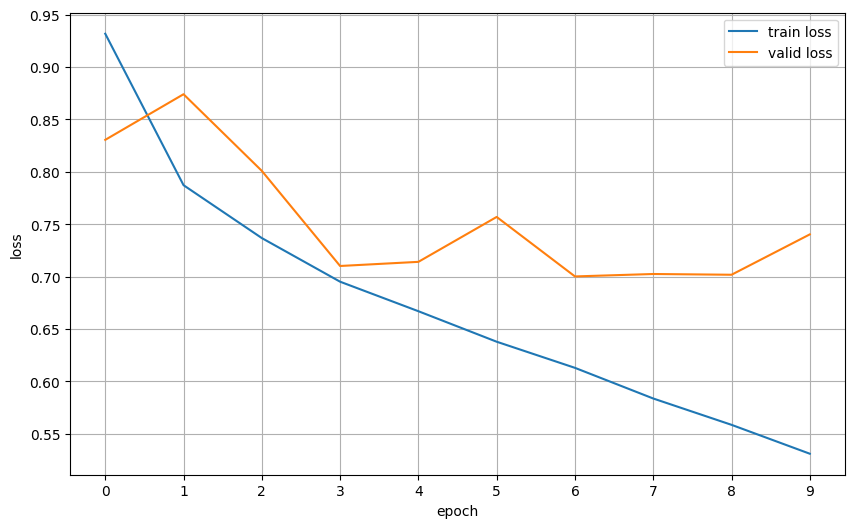

In [95]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

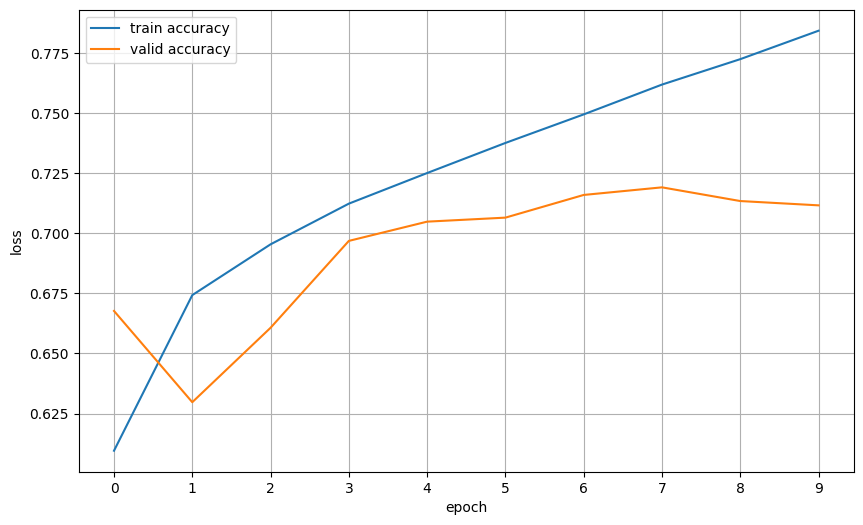

In [96]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [97]:
def tokenize_example(sentence, tokenizer, max_length):
    tokens = tokenizer(sentence)[:max_length]
    return {"tokens": tokens, "length": len(tokens)}


In [98]:
def numericalize_example(row, vocab):
    ids = vocab.lookup_indices(row["tokens"])
    return {"ids": ids, "length": row["length"]}


In [99]:
max_length=256

In [100]:
# Token+ Numer test Data
test_data["tokenized"] = test_data["sentence"].apply(
    lambda x: tokenize_example(x, tokenizer, max_length)
)

test_data["numericalized"] = test_data["tokenized"].apply(
    lambda x: numericalize_example(x, vocab)
)

print("test data tokenized and numericalized:")
print(test_data.head())



test data tokenized and numericalized:
      text_id                                           sentence  \
0  r1-0086521  A helpful valet at the Bellagio said it was a ...   
1  r1-0044715  People often ask "what happened to the human c...   
2  r1-0060690  He explained there would be a diagnostic fee o...   
3  r1-0016852    I had initially purchased a massage on Groupon.   
4  r2-0006040  Primarily do high-end cars as they get referra...   

                                           tokenized  \
0  {'tokens': ['a', 'helpful', 'valet', 'at', 'th...   
1  {'tokens': ['people', 'often', 'ask', 'what', ...   
2  {'tokens': ['he', 'explained', 'there', 'would...   
3  {'tokens': ['i', 'had', 'initially', 'purchase...   
4  {'tokens': ['primarily', 'do', 'high-end', 'ca...   

                                       numericalized  
0  {'ids': [5, 726, 1517, 23, 2, 4138, 93, 10, 7,...  
1  {'ids': [96, 561, 226, 59, 818, 6, 2, 2743, 41...  
2  {'ids': [51, 752, 30, 49, 29, 5, 4171, 1025, 8.

In [101]:
print(test_data["numericalized"].head())
print(test_data.shape)


0    {'ids': [5, 726, 1517, 23, 2, 4138, 93, 10, 7,...
1    {'ids': [96, 561, 226, 59, 818, 6, 2, 2743, 41...
2    {'ids': [51, 752, 30, 49, 29, 5, 4171, 1025, 8...
3    {'ids': [3, 22, 1874, 571, 5, 660, 16, 639, 0]...
4    {'ids': [4250, 76, 0, 922, 32, 19, 37, 7861, 4...
Name: numericalized, dtype: object
(5110, 4)


In [102]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [torch.tensor(row["numericalized"]["ids"]) for row in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = torch.tensor([row["numericalized"]["length"] for row in batch])

        # Exclude label for dev data
        batch = {"ids": batch_ids, "length": batch_length}
        return batch

    return collate_fn

In [103]:
# Create DataLoader for Dev Data
test_data_loader = get_data_loader(test_data, batch_size, pad_index, shuffle=False)

print("Test DataLoader created.")


Test DataLoader created.


In [104]:
# Load the best saved model
model.load_state_dict(torch.load("lstm.pt"))
model = model.to(device)

print("Best model loaded.")


Best model loaded.


In [105]:
def predict_test(dataloader, model, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="Predicting on test data..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            outputs = model(ids, length)
            predicted_classes = outputs.argmax(dim=-1).cpu().numpy()
            predictions.extend(predicted_classes)

    return predictions



In [106]:
predictions = predict_test(test_data_loader, model, device)

# 10 predictions
print("Sample Predictions (Class Indices):", predictions[:10])  # These will be 0, 1, or 2



Predicting on test data...: 100%|██████████| 80/80 [00:04<00:00, 19.49it/s]

Sample Predictions (Class Indices): [2, 1, 1, 1, 0, 0, 1, 2, 1, 1]


In [107]:
# mapping back to original labels
index_to_label = {0: -1, 1: 0, 2: 1}

mapped_predictions = [index_to_label[pred] for pred in predictions]

# Save 'answer_dev.txt'
with open("answer_dev.txt", "w") as f:
    for prediction in mapped_predictions:
        f.write(f"{prediction}\n")

print("Predictions saved to 'answer_dev.txt'.")


Predictions saved to 'answer_dev.txt'.


In [108]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [109]:
text = "This film is little terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9999998807907104)

In [110]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(2, 0.9971247315406799)

In [111]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(2, 0.5023961663246155)

In [112]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9999780654907227)